Sometimes, rather than estimating a value, we're looking to answer a yes or no question about each hypothesis, and thus classify them into two groups. For example, suppose we were constructing a Hall of Fame, where we wanted to include all players that have a 2-pointer-percentage greater than .440. We want to include as many players as we can, but we need to be sure that each belongs.

The problem of *hypothesis testing* appears whenever we're trying to identify candidates for future study. We need a principled approach to decide which players are worth including, and that can handle multiple testing problems. To solve this, we're going to apply a Bayesian approach to a method usually associated with frequentist statistics, namely **false discovery rate control**.

In data science, knowing how to work with posterior predictions for many observations, and come up with a set of candidates for further study, is an essential skill.

## Setup Dataset

In [1]:
import os
import math
import pandas as pd
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
project_dir = '/mnt/data-ubuntu/Projects/statistics_python3'
df = pd.read_csv(project_dir + '/data/nba-players-stats/seasons_stats_pg.csv')

In [2]:
data = df.loc[:,'2P%'][(df.loc[:,'2P%']<1) & (df.loc[:,'2P%']>0)]
beta_fit = beta.fit(data = data, floc=0, fscale=1)
a = round(beta_fit[0], 2)
b = round(beta_fit[1], 2)
print(f'a: {a},b: {b}')
df.head()

a: 23.05,b: 29.35


,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high
0,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,0.343504,166.05,317.35,0.301850,0.386385
1,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,0.361986,340.05,599.35,0.331557,0.392972
2,1950.0,Dick McGuire*,PG,190.0,563.0,0.337478,0.346198,213.05,402.35,0.309128,0.384214
3,1950.0,Fred Scolari,PG,312.0,910.0,0.342857,0.348140,335.05,627.35,0.318365,0.378513
4,1950.0,George Senesky,PG,227.0,709.0,0.320169,0.328408,250.05,511.35,0.295510,0.362160


In [3]:
# Based on the performance of C.J. Watson in the 2017,
# should he be in the Hall of Fame?

df_temp = df \
    .query('Year == 2017 & Player == "C.J. Watson"') \
    .loc[:, ['Player', '2P', '2PA', '2P%_estimate', 'a_i', 'b_i']]

df_temp

,Player,2P,2PA,2P%_estimate,a_i,b_i
3700,C.J. Watson,64.0,143.0,0.445496,87.05,108.35


## Calculate Posterior Error Probabilities for C.J. Watson

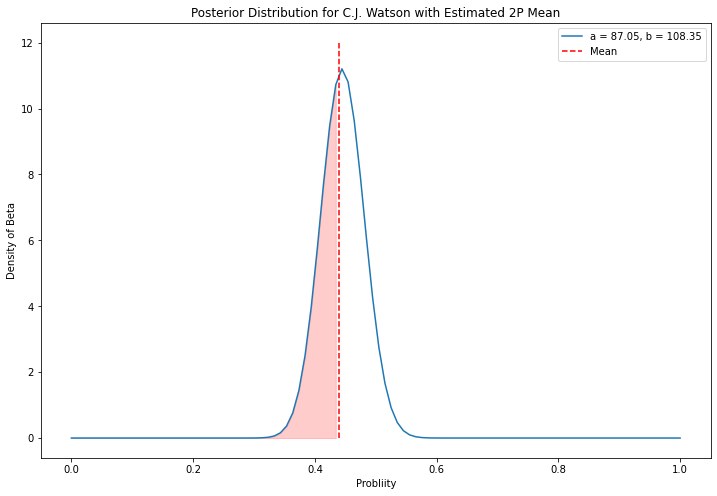

In [4]:
# Plot the posterior distribution for C.J. Watson
fig,ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0,1,100)
a_i = df_temp.loc[:,'a_i'].values[0]
b_i = df_temp.loc[:,'b_i'].values[0]
df_temp = pd.DataFrame({'Probability': x, f'a = {a_i}, b = {b_i}': beta.pdf(x, a_i, b_i)})
df_temp.set_index('Probability') \
    .plot(ax = ax)

# Plot the Mean
y_l = np.linspace(0, 12, 100)
x_l = [(a/(a+b))] * len(y_l)
plt.plot(x_l, y_l, linestyle='--',color = 'red', label='Mean')

# Plot the shade
plt.fill_between(x, beta.pdf(x, a_i, b_i), where=x<=(a/(a+b)), alpha=0.2, color='red')
plt.ylabel('Density of Beta')
plt.xlabel('Probliity')
plt.title('Posterior Distribution for C.J. Watson with Estimated 2P Mean')
legend = ax.legend(loc='upper right')
plt.show()

We can see that there is a nonzero probability (shaded) that his true probability of getting goals is less than .44. We can calculate this error probability with the cumulative
distribution function (CDF) of the beta distribution.

This probability that a player doesn't belong in the Hall of Fame is called the **Posterior Error Probability**.

For most players, it's almost certain that they don't belong in the Hall of Fame: we know that their 2P% estimate are far below .44. If they were included, it is almost certain that they would be an error. 

In the middle are the borderline players: the ones where we're not sure, such as C.J. Watson. And down there close to 0 are the rare but proud players who we're (effectively) certain belong in the hall of fame.

In [5]:
print(f'The PEP for C.J. Watson is {beta.cdf(a/(a+b), a_i, b_i)}.')

The PEP for C.J. Watson is 0.4393947027626849.


In [6]:
# Calculate the Posterior Error Probability for all players
# Note the data is grouped by year and player. 
# So, for example, if the same player is within the threshold in two years, 
# the player will be in the Hall of Fame twice.
df['PEP'] = df.apply(lambda x: beta.cdf(a/(a+b), x.a_i, x.b_i), axis = 1)
df.sort_values('PEP', inplace = True)
df.head()

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high,PEP
1246,1988.0,John Stockton*,PG,430.0,724.0,0.593923,0.583527,453.05,323.35,0.548679,0.617967,4.987049e-16
1811,1996.0,Anfernee Hardaway,PG,534.0,932.0,0.572961,0.565878,557.05,427.35,0.534811,0.596690,1.130444e-15
1082,1985.0,Magic Johnson*,PG,497.0,862.0,0.576566,0.568734,520.05,394.35,0.536516,0.600666,2.803071e-15
2793,2006.0,Tony Parker,PG,612.0,1100.0,0.556364,0.551067,635.05,517.35,0.522284,0.579683,1.902598e-14
1022,1984.0,Magic Johnson*,PG,435.0,751.0,0.579228,0.570139,458.05,345.35,0.535772,0.604176,6.652018e-14


## False Discovery Rate

Now we want to set some **threshold** for inclusion in our Hall of Fame. This criterion is up to us: what kind of goal do we want to set? There are many options, but I'll propose one common in statistics: let's try to include as many players as possible, while ensuring that no more than 5% of the Hall of Fame was mistakenly included. 

This criterion is called **false discovery rate control**. It's particularly relevant in scientific studies, where we might want to come up with a set of candidates for future study. There's nothing special about 5%: if we wanted to be more strict, we could choose the same policy, but change our desired FDR to 1% or .1%. Similarly, if we wanted a broader set of candidates to study, we could set an FDR of 10% or 20%.

In [7]:
# Let's see we chose to take the top 1300 rows for our Hall of Fame. 
df_top = df.iloc[:1300, :]

# Calculate the expected value of the total number of false positives.
sum(df_top.PEP)/1300

0.05129778224541489

If we chose the top 1300 rows, we are pretty close to our target of 5%.

## Q-values

We could experiment with many thresholds to get our desired FDR for each. But
it's even easier just to compute them all thresholds at once, by computing the
cumulative mean of all the (sorted) posterior error probabilities. This cumulative mean is called a **q-value**.

In [8]:
df['q_value'] = df.loc[:, 'PEP'].expanding().mean()
df.head()

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high,PEP,q_value
1246,1988.0,John Stockton*,PG,430.0,724.0,0.593923,0.583527,453.05,323.35,0.548679,0.617967,4.987049e-16,4.987049e-16
1811,1996.0,Anfernee Hardaway,PG,534.0,932.0,0.572961,0.565878,557.05,427.35,0.534811,0.596690,1.130444e-15,8.145743e-16
1082,1985.0,Magic Johnson*,PG,497.0,862.0,0.576566,0.568734,520.05,394.35,0.536516,0.600666,2.803071e-15,1.477407e-15
2793,2006.0,Tony Parker,PG,612.0,1100.0,0.556364,0.551067,635.05,517.35,0.522284,0.579683,1.902598e-14,5.864550e-15
1022,1984.0,Magic Johnson*,PG,435.0,751.0,0.579228,0.570139,458.05,345.35,0.535772,0.604176,6.652018e-14,1.799568e-14


In [9]:
df[df['q_value']<=.05].count()[0]

1289

In [10]:
q = 0.05
total_num = df[df['q_value']<=.05].count()[0]
print(f'There are {total_num} rows will be in the Hall of Fame, if we set q value at {q}.')

There are 1289 rows will be in the Hall of Fame, if we set q value at 0.05.


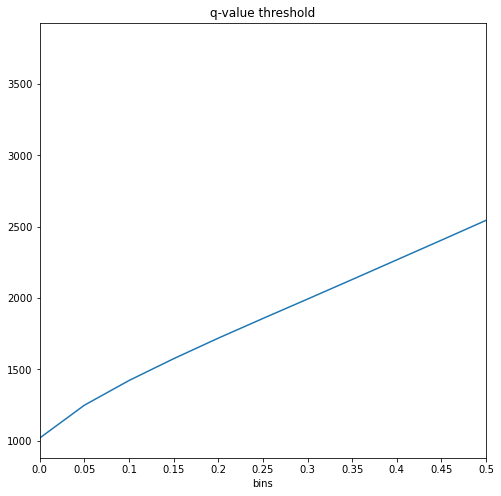

In [11]:
# Plot the q-value threshold.
fig, ax = plt.subplots(figsize = (8, 8))
df['bins'] = pd.cut(df.loc[:, 'q_value'], 20)
df_temp = df \
    .groupby('bins') \
    .count() \
    .loc[:,'q_value'] \
    .cumsum()

df_temp \
    .plot()

# positions of each tick, relative to the indices of the x-values
pos = list(range(21))
ax.set_xticks(pos)

# labels
ax.set_xticklabels([round(p,2) for p in np.arange(0, 1.05, 0.05)])

plt.xlim(0, 10)
plt.title('q-value threshold')
plt.show()

It's useful to look at how many rows would be included at various q-value thresholds. This shows that you could include 1800 rows in the Hall of Fame, but at that point you'd expect that more than 20% of them would be incorrectly included. On the other side, you could create a hall of 1000 players and be very confident that all of them have a batting probability of .44.